In [1]:
import matplotlib.pyplot as plt

In [2]:
import math
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import KFold
import random

In [3]:
torch.set_default_dtype(torch.float32)

This is adapted from a group project I did for STAT 27400

The objective was to extend the Bradley-Terry model for pairwise comparisons with a GAM. This way, an *interpretable* function mapping a team's covariates (e.g. 3pt%, ball possession %, etc) to a team's Bradley-Terry strength could be determined, giving insights on the 'direction of most improvement' given finite resources (e.g. a coach can realize that increasing 3pt% a certain amount may be more worthwhile towards winning than increasing ball possession %)

# Ground Truth

Example functions

In [4]:
def f1(x):
    return (-0.5*x**2 + 1.5*x)
    #return -x
def f2(x):
    return np.sin(2*x)*.5
    #return x
def f3(x):
    return (np.exp(-.8*x) - 1 + 2*x)
    #return 0.5*x**2

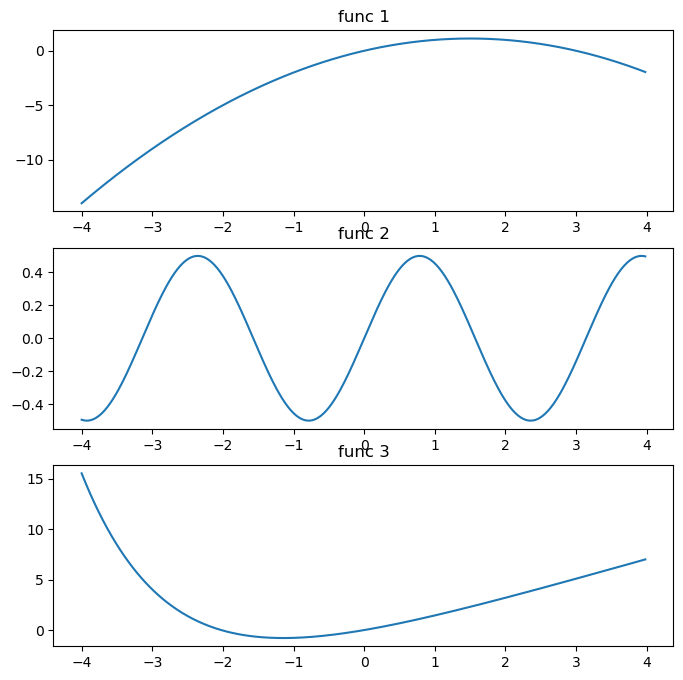

In [5]:
X = np.arange(-4, 4, .02)
Y1 = f1(X)
Y2 = f2(X)
Y3 = f3(X)

fig, axs = plt.subplots(3,1, figsize=(8,8))
for i,Y in enumerate([Y1, Y2, Y3]):
    axs[i].plot(X, Y)
    axs[i].set_title(label='func {}'.format(i+1))

In [5]:
n_players = 128
playerstats = np.random.normal(0,1.25,(n_players,3))
playerstrengths = np.zeros(n_players)
playerstrengths += f1(playerstats[:,0])
playerstrengths += f2(playerstats[:,1])
playerstrengths += f3(playerstats[:,2])

# adding noise
playerstrengths += np.random.normal(0,.25,n_players)
playerstrengths -= np.median(playerstrengths)

(array([ 1.,  2.,  0.,  6., 15., 36., 50., 14.,  1.,  3.]),
 array([-11.99905963, -10.01458718,  -8.03011473,  -6.04564229,
         -4.06116984,  -2.07669739,  -0.09222494,   1.8922475 ,
          3.87671995,   5.8611924 ,   7.84566484]),
 <BarContainer object of 10 artists>)

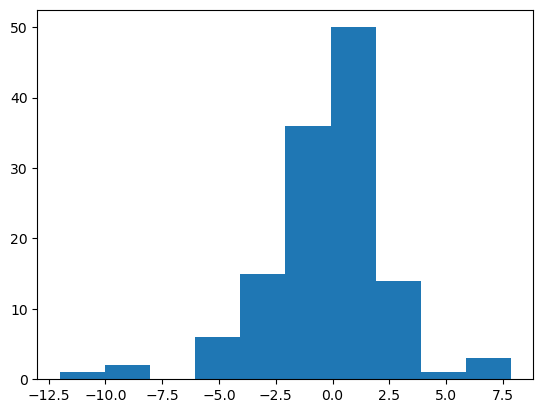

In [6]:
plt.hist(playerstrengths, 10)

# Simulating Games:

Each pair of players plays 3 times against each other

In [8]:
rand = False

games = []
records = pd.DataFrame(0, index=range(n_players), columns=['W', 'L', 'pct'])
records['strength'] = playerstrengths


if not rand:
    for i in range(n_players):
        for j in range(i+1, n_players):
            strength1 = playerstrengths[i]
            strength2 = playerstrengths[j]
            diff = strength1 - strength2
            p = np.exp(diff) / (1 + np.exp(diff))
            
            n_games = 3

            results = np.random.binomial(1, p, n_games)
            for res in results:
                games.append((res, i, j))
else:
    pass
            
for res, i, j in games:
    if res == 1:
        records.iloc[i,0] += 1 
        records.iloc[j,1] += 1
    else:
        records.iloc[i,1] += 1 
        records.iloc[j,0] += 1
records['pct'] = records['W'] / (records['W'] + records['L'])        

In [9]:
records.sort_values('pct', ascending=False)

,W,L,pct,strength
62,378,3,0.992126,7.011107
75,378,3,0.992126,7.845665
27,373,8,0.979003,5.976269
80,363,18,0.952756,4.808776
54,345,36,0.905512,3.368236
...,...,...,...,...
101,20,361,0.052493,-5.682935
38,17,364,0.044619,-5.322992
53,8,373,0.020997,-8.061836
59,4,377,0.010499,-9.345035


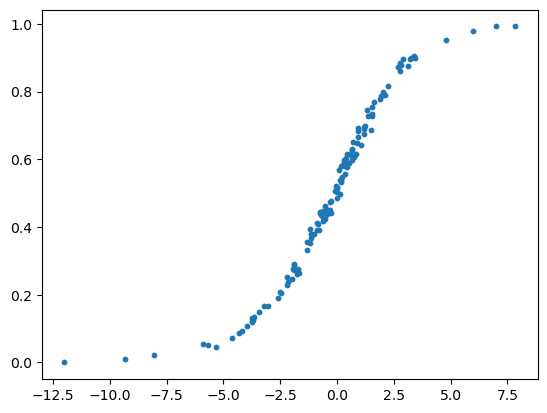

In [10]:
plt.scatter(records['strength'], records['pct'], s=10)

# Now, GAM:

In [11]:
def gaussian_kernel(X1_tensor, X2_tensor, j=None, h=1):
    if j is None:
        pairwise_sq_dists = torch.cdist(X1_tensor, X2_tensor, p=2)**2
    else:
        X1_j = X1_tensor[:, j].unsqueeze(1)  # Shape: n1 x 1
        X2_j = X2_tensor[:, j].unsqueeze(1)  # Shape: n2 x 1
        pairwise_sq_dists = torch.cdist(X1_j, X2_j, p=2)**2
        
    K = torch.exp(-pairwise_sq_dists / (2 * h**2))
    return K

def precompute_kernels(X1_tensor, X2_tensor, h=1):
    n1, d = X1_tensor.shape
    n2 = X2_tensor.shape[0]
    kernel_tensor = torch.zeros(d, n1, n2)

    for j in range(d):
        kernel_tensor[j, :, :] = gaussian_kernel(X1_tensor, X2_tensor, j, h)

    return kernel_tensor

def delta_f(theta, games, kernel_tensor):
    G = games.shape[0]
    d = theta.shape[0]
    delta = torch.zeros(G)

    for j in range(d):
        K_j = kernel_tensor[j, :, :]  # n x n
        g1_indices = games[:, 1].long()
        g2_indices = games[:, 2].long()
        delta += torch.matmul(K_j[g1_indices], theta[j]) - torch.matmul(K_j[g2_indices], theta[j])
    
    return delta

# now centered at 0
def f_j(j, x_values_new, X_tensor_train, theta, h):
    X_new_j = x_values_new.unsqueeze(1)  # Shape: n2 x 1
    X_j = X_tensor_train[:, j].unsqueeze(1)  # Shape: n1 x 1
    
    K_j_new = gaussian_kernel(X_new_j, X_j, j=None, h=h)
    K_j_0 = gaussian_kernel(torch.zeros((1, 1)), X_j, j=None, h=h)
    f_j_new_values = torch.matmul(K_j_new, theta[j])
    
    zero_f_j = torch.matmul(K_j_0, theta[j])
    
    # Subtract f_j(0) from all values
    f_j_adjusted_values = f_j_new_values - zero_f_j
    
    return f_j_adjusted_values

def objective_function(alpha, theta, games, kernel_tensor, lbda):
    G = games.shape[0]
    y_g = games[:, 0]  # G tensor
    g1_indices = games[:, 1].long()  # G tensor
    g2_indices = games[:, 2].long()  # G tensor

    # Compute delta for all games
    delta = delta_f(theta, games, kernel_tensor)

    # Vectorized computation of the objective function
    alpha_diff = alpha[g1_indices] - alpha[g2_indices]  # G tensor
    logits = alpha_diff + delta  # G tensor

    # Objective function
    obj = torch.sum(y_g * logits - torch.log(1 + torch.exp(logits)))
    
    d = theta.shape[0]
    regularization = 0
    for j in range(d):
        K_j = kernel_tensor[j, :, :]
        regularization += torch.matmul(theta[j], torch.matmul(K_j, theta[j]))
        
    return -obj/G + lbda * regularization

In [12]:
def optimize_theta(X_tensor, games, h=1.0, lbda=1.0, lr=0.01, epochs=500, show_progress=True):
    G = games.shape[0]
    n, d = X_tensor.shape

    alpha = torch.zeros(n, requires_grad=False)
    theta = torch.zeros(d, n, requires_grad=True)

    kernel_tensor = precompute_kernels(X_tensor, X_tensor, h)
    
    optimizer = torch.optim.Adam([theta], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.9)

    for epoch in tqdm(range(epochs), display=show_progress):
        optimizer.zero_grad()
        loss = objective_function(alpha, theta, games, kernel_tensor, lbda)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if show_progress and (epoch % (epochs//10) == 0):
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return theta

In [13]:
def optimize_alpha(X_tensor, theta, games, h=1.0, lbda=1.0, lr=0.01, epochs=500, show_progress=True):
    G = games.shape[0]
    n, d = X_tensor.shape

    alpha = torch.zeros(n, requires_grad=True)

    kernel_tensor = precompute_kernels(X_tensor, X_tensor, h)
    
    optimizer = torch.optim.Adam([alpha], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.9)

    for epoch in tqdm(range(epochs), display=show_progress):
        optimizer.zero_grad()
        loss = objective_function(alpha, theta, games, kernel_tensor, lbda)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if show_progress and (epoch % (epochs//10) == 0):
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return alpha

In [14]:
def plot_GAM(j, x_values_new, X_tensor, theta, true_func= None, h=1):
  
    # Compute f^{(j)*} values
    f_j_values = f_j(j, x_values_new, X_tensor, theta, h)
    f_j_old = f_j(j, X_tensor[:,j], X_tensor, theta, h)

    # Convert tensors to numpy arrays for plotting
    x_values_new_np = x_values_new.numpy()
    f_j_values_np = f_j_values.detach().numpy()
    
    f_j_old = f_j_old.detach().numpy()
    x_values_old = X_tensor[:,j].detach().numpy()

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.scatter(x_values_old, f_j_old, s=6, label='training values', color='red')
    plt.plot(x_values_new_np, f_j_values_np, label='covariate {}'.format(j), color='blue')
    if true_func:
        true_vals = true_func(x_values_new_np)
        plt.plot(x_values_new_np, true_vals, label='true func', color='green', linestyle='--')
    plt.xlabel(f'$x_{{j}}$')
    plt.ylabel(f'$f^{{({j})*}}(x_{{{j}}})$')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def predict_new_matches(alpha, theta, new_games, X_tensor_train, X_tensor_new, h):

    G_2 = new_games.shape[0]
    n, d = X_tensor.shape
    
    player_strengths = alpha.clone()
    for j in range(d):
        player_strengths += f_j(j, X_tensor_new[:,j], X_tensor_train, theta, h)
   
    pred_probs = torch.zeros(G_2)
    for g in range(G_2):
        g1 = new_games[g,1].int()
        g2 = new_games[g,2].int()
        pred_probs[g] = torch.sigmoid(player_strengths[g1]-player_strengths[g2])
    return pred_probs 

In [30]:
def compare_strenghts(true_strengths, alpha, theta, X_tensor, h):
    n, d = X_tensor.shape
    
    pred_strengths = alpha.clone()
    for j in range(d):
        pred_strengths += f_j(j, X_tensor[:,j], X_tensor, theta, h)
   
    
    pred_strengths = pred_strengths.detach().numpy()
    first_offset = pred_strengths[0] - true_strengths[0]
    pred_strengths -= first_offset
    df = pd.DataFrame()
    df['true'] = true_strengths
    df['pred'] = pred_strengths
    
    m, M = (min(true_strengths), max(true_strengths))
    
    plt.scatter(df['true'], df['pred'], label='data')
    plt.plot([m,M],[m,M], color='red', label='y=x')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.legend()
    return df

In [17]:
def get_testing_loss(alpha, theta, new_games, X_tensor_train, X_tensor_new, h):
   
    Y_true = new_games[:, 0]
    
    pred_probs = predict_new_matches(alpha, theta, new_games, X_tensor_train, X_tensor_new, h)
    
    loss = - (Y_true * torch.log(pred_probs) + (1 - Y_true) * torch.log(1 - pred_probs))
    return torch.mean(loss)

In [18]:
def get_accuracy(alpha, theta, new_games, X_tensor_train, X_tensor_new, h):
    Y_true = new_games[:, 0]
    
    pred_probs = predict_new_matches(alpha, theta, new_games, X_tensor_train, X_tensor_new, h)
    pred = (pred_probs >= 0.5).int()
    
    correct = (Y_true == pred).float()
    return torch.mean(correct)

In [19]:
def get_unique_player_indices(games):
    return torch.unique(games[:, 1:].flatten())

def filter_games_by_players(games, player_indices):
    mask = (torch.isin(games[:, 1], player_indices) & torch.isin(games[:, 2], player_indices))
    return games[mask]

def adjust_game_indices(games, player_indices):
    index_map = {player_indices[i].item(): i for i in range(len(player_indices))}
    
    adjusted_games = games.clone()
    for g in range(games.shape[0]):
        adjusted_games[g, 1] = index_map[int(games[g, 1].item())]
        adjusted_games[g, 2] = index_map[int(games[g, 2].item())]
    return adjusted_games

def cross_validate_h(X_tensor, games, hs=[0.1, 1.0, 10.0], lbda=1.0,
                     lr=0.01, epochs=100, k_folds=10, show_progress=True):
    kf = KFold(n_splits=k_folds, shuffle=True)
    losses = []
    splits = list(kf.split(range(X_tensor.shape[0])))  # Splitting player indices

    for h in tqdm(hs, disable=not show_progress):
        avg_loss = 0.0
        
        for train_index, val_index in tqdm(splits, disable=not show_progress, leave=False):
            train_players = torch.tensor(train_index)
            val_players = torch.tensor(val_index)
            
            X_train = X_tensor[train_players]
            X_val = X_tensor[val_players]

            # Filter games based on train players
            train_games = filter_games_by_players(games, train_players)
            val_games = filter_games_by_players(games, val_players)

            # Adjust game indices to match the filtered X_tensor
            train_games_adjusted = adjust_game_indices(train_games, train_players)
            val_games_adjusted = adjust_game_indices(val_games, val_players)

            # Optimize theta on the training set
            theta = optimize_theta(X_train, train_games_adjusted, h=h,
                                   lbda=lbda, lr=lr, epochs=epochs, show_progress=False)

            # Compute validation loss
            alpha_0_val = torch.zeros(X_val.shape[0])
            val_loss = get_testing_loss(alpha_0_val, theta, val_games_adjusted, X_train, X_val, h=h)
            avg_loss += val_loss.item()

        avg_loss /= k_folds
        
        print(f'h: {h}, Avg Loss: {avg_loss}')
        
        losses.append(avg_loss)
    
    plt.plot(hs, losses, color='blue')
    plt.scatter(hs, losses, color='red')
    plt.xscale('log')
    plt.xlabel('log(h)')
    plt.ylabel('Avg. Loss')
    plt.title('K-Fold CV, K={}'.format(k_folds))
    plt.grid(True)
    plt.show()
    
    return hs[min(range(len(losses)), key=losses.__getitem__)]

In [20]:
X_tensor = torch.from_numpy(playerstats).type(torch.float32)
games_tensor = torch.from_numpy(np.asarray(games)).type(torch.float32)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

h: 0.1, Avg Loss: 0.5127594172954559


  0%|          | 0/4 [00:00<?, ?it/s]

h: 0.3, Avg Loss: 0.4054560214281082


  0%|          | 0/4 [00:00<?, ?it/s]

h: 1, Avg Loss: 0.3867540806531906


  0%|          | 0/4 [00:00<?, ?it/s]

h: 2, Avg Loss: 0.39715415984392166


  0%|          | 0/4 [00:00<?, ?it/s]

h: 5, Avg Loss: 0.3899005576968193


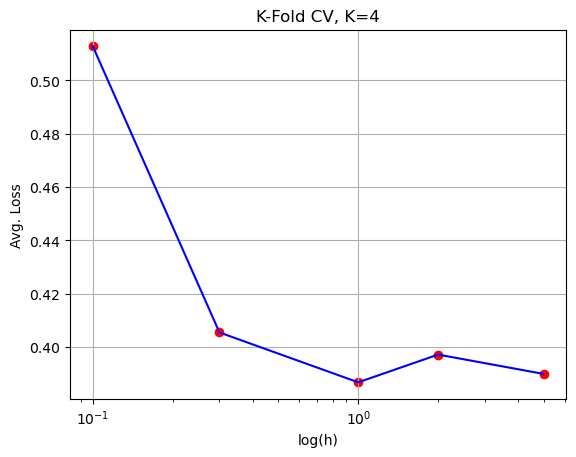

In [22]:
h_opt = cross_validate_h(X_tensor, games_tensor, hs=[.1, .3, 1, 2, 5], lbda=0,
                         lr=0.01, epochs=100, k_folds=4, show_progress=True)

In [22]:
h = h_opt
X_tensor = torch.from_numpy(playerstats).type(torch.float32)
games_tensor = torch.from_numpy(np.asarray(games)).type(torch.float32)
theta_opt = optimize_theta(X_tensor, games_tensor, h=h, lbda = 0, lr=.01, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 0.6931473612785339
Epoch 20, Loss: 0.3887982964515686
Epoch 40, Loss: 0.36074337363243103
Epoch 60, Loss: 0.35600316524505615
Epoch 80, Loss: 0.3547629714012146
Epoch 100, Loss: 0.3542240858078003
Epoch 120, Loss: 0.3538733422756195
Epoch 140, Loss: 0.35359370708465576
Epoch 160, Loss: 0.35335955023765564
Epoch 180, Loss: 0.3531601130962372


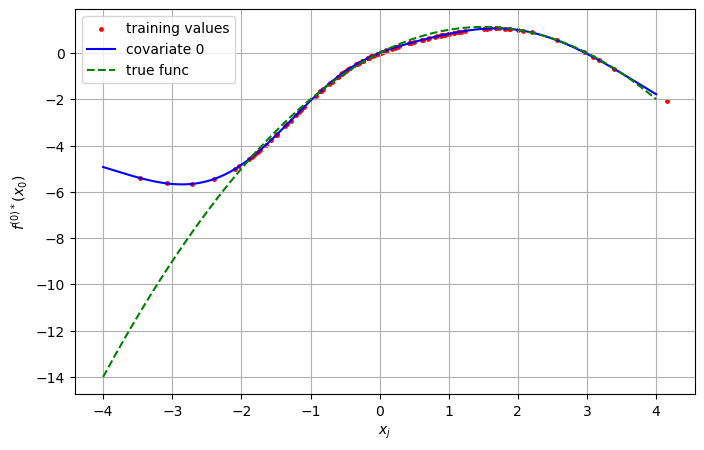

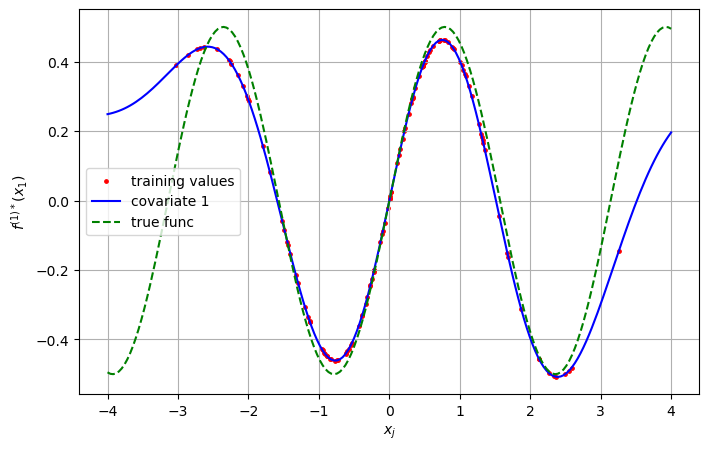

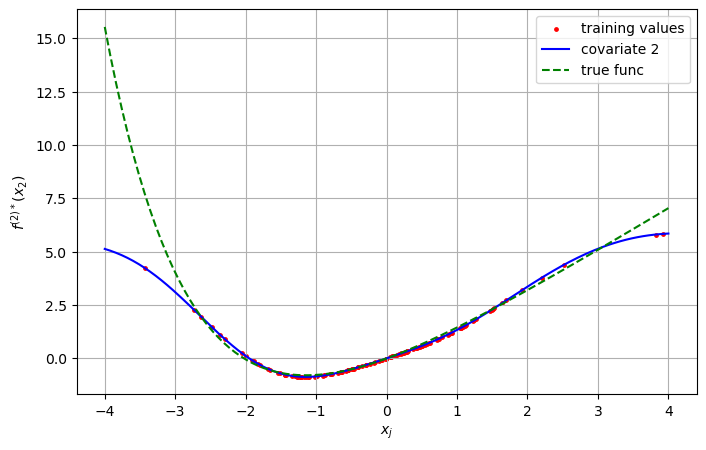

In [23]:
funcs = [f1, f2, f3]
for J in range(3):
    plot_GAM(J, torch.linspace(-4, 4, 200), X_tensor, theta_opt, funcs[J], h=h)

,true,pred
0,-1.156218,-1.156218
1,1.058078,0.377062
2,-0.457749,-0.475659
3,0.722421,0.391634
4,1.172524,1.235905
...,...,...
123,-1.907761,-1.836789
124,-3.756532,-3.302625
125,-0.771378,-0.436406
126,0.269786,0.145963


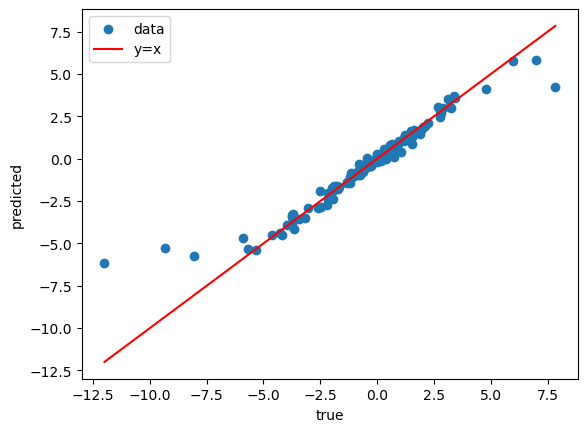

In [31]:
compare_strenghts(playerstrengths, torch.zeros(X_tensor.shape[0]), theta_opt, X_tensor, h=h)

In [27]:
rand_inds = np.random.choice(a=games_tensor.shape[0], replace=False, size=10000)
acc = get_accuracy(torch.zeros(X_tensor.shape[0]), theta_opt, games_tensor[rand_inds], X_tensor, X_tensor, h=h)
print('training accuracy: {:.5f}'.format(acc))

training accuracy: 0.83620
